# Xgboost with handcraft feature
In this notebook, we will use the xgboos to model the handcrafted features and make classification on the similarity of the two queries.

In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib
import os

import matplotlib.pyplot as plt
%matplotlib inline

/home/peiran/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Text Retrieval

### Load data

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [4]:
test.head(2)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


### Text processing

In [7]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [8]:
# transform to one column for tfidf transformation
# tfidf_input = pd.Series(train["question1"].tolist() + \
#               train["question2"].tolist() + \
#               test["question1"].tolist()  + \
#               test["question2"].tolist()).astype(str)

# tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
# tfidf.fit_transform(tfidf_input)

In [9]:
def get_common_ratio(seq1,seq2):
    """
    This function is to compare and get the ratio of similarity between two sequences
    """
    seqMatch = difflib.SequenceMatcher(a=seq1, b=seq2)
    return seqMatch.ratio()

In [10]:
def get_common_bigrams_ratio(list1,list2):
    seqMatch = difflib.SequenceMatcher(a=list1, b=list2)
    return seqMatch.ratio()

In [11]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [12]:
def get_bigrams(que):
    return [" ".join(list(map(lambda x: str(x).strip(","),i))) for i in nltk.ngrams(str(que).split(), 2)]

In [13]:
def extract_feat(feat_mat):
    """
    To extract features from q1 and q2
    """
    print("1..")
    # extract nouns
    feat_mat["z1_nouns"] = feat_mat.question1.apply( \
        lambda x: [str(w).lower() for w,t in \
                   nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[0] == "N"])
    feat_mat["z2_nouns"] = feat_mat.question2.apply( \
        lambda x: [str(w).lower() for w,t in \
                   nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[0] == "N"])
    
    print("2..")
    # extract none match counts and ratio
    feat_mat["z_noun_match"] = feat_mat[["z1_nouns","z2_nouns"]].apply(
        lambda x: len([w for w in x.z1_nouns if w in x.z2_nouns]),
        axis = 1)
    
    feat_mat['z_noun_match_ratio'] = feat_mat.apply( \
        lambda x: get_common_ratio(x.z1_nouns, x.z2_nouns), 
        axis=1)
    
    print("3..")
    # extract length
    feat_mat["z1_len"] = feat_mat["question1"].apply( \
        lambda x: len(str(x)))
    feat_mat["z2_len"] = feat_mat["question2"].apply( \
        lambda x: len(str(x)))
    feat_mat["z1_word_len"] = feat_mat["question1"].apply( \
        lambda x: len(str(x).split()))
    feat_mat["z2_word_len"] = feat_mat["question2"].apply( \
        lambda x: len(str(x).split()))
    
    print("4..")
    # extract word match
    feat_mat['z_word_match'] = feat_mat.apply(word_match_share, axis=1, raw=True)
    
    # extract bigrams
    feat_mat['z1_bigrams'] = feat_mat["question1"].apply(get_bigrams)
    feat_mat['z2_bigrams'] = feat_mat["question2"].apply(get_bigrams)
    
    # extract common bigrams
    feat_mat['z_common_bigrams'] = feat_mat[['z1_bigrams','z2_bigrams']].apply(
        lambda x: get_common_bigrams_ratio(x.z1_bigrams,x.z2_bigrams), axis = 1)
    
    # processing
    feat_mat = feat_mat.drop(['z1_bigrams','z2_bigrams',"z1_nouns","z2_nouns"],axis=1)
    feat_mat = feat_mat.fillna(-1)
    
    return feat_mat

extract features and scale the amount of positive and negative data

In [14]:
train = extract_feat(train)

1..
2..
3..
4..


In [15]:
test = extract_feat(test)

1..
2..
3..
4..


In [16]:
train_col = [x for x in train.columns if x[0] == "z"]
test_col = [x for x in test.columns if x[0] == "z"]

In [17]:
train_col

['z_noun_match',
 'z_noun_match_ratio',
 'z1_len',
 'z2_len',
 'z1_word_len',
 'z2_word_len',
 'z_word_match',
 'z_common_bigrams']

In [18]:
pos_train = train[train['is_duplicate'] == 1]
neg_train = train[train['is_duplicate'] == 0]
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1

while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
    
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train = pd.concat([pos_train, neg_train])

train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train[train_col], train["is_duplicate"],
                                                    test_size = 0.3, random_state = 0)

In [20]:
y_train.shape

(546340,)

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [22]:
params = {
    'min_child_weight': 1,
    'eta': 0.01,
    'colsample_bytree': 1,
    'max_depth': 12,
    'subsample': 0.2,
    'reg_alpha': 1,
    'gamma': 0.04,
    'silent':True,
    "eval_metric":"logloss"}

In [23]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgval = xgb.DMatrix(X_test, label=y_test)

In [24]:
# fit model no training data
gb_model = xgb.train(params, 
                     dtrain=xgtrain, 
                     verbose_eval = 50,
                     evals=[(xgval,"validation")], 
                     early_stopping_rounds = 50,
                     num_boost_round = 2000)

[0]	validation-logloss:0.687868
Will train until validation-logloss hasn't improved in 50 rounds.
[50]	validation-logloss:0.51523
[100]	validation-logloss:0.434243
[150]	validation-logloss:0.39168
[200]	validation-logloss:0.367965
[250]	validation-logloss:0.354093
[300]	validation-logloss:0.345717
[350]	validation-logloss:0.340502
[400]	validation-logloss:0.337139
[450]	validation-logloss:0.334666
[500]	validation-logloss:0.332651
[550]	validation-logloss:0.331466
[600]	validation-logloss:0.330851
[650]	validation-logloss:0.32978
[700]	validation-logloss:0.329222
[750]	validation-logloss:0.32849
[800]	validation-logloss:0.328742
Stopping. Best iteration:
[755]	validation-logloss:0.328412



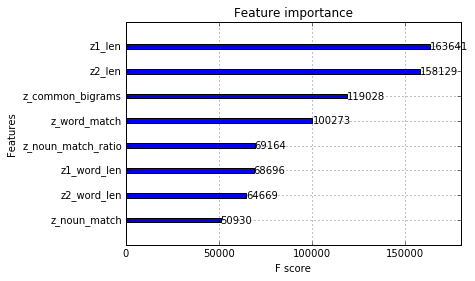

In [25]:
xgb.plot_importance(gb_model)
plt.show()

best cv: 0.328412

### prediction and submission

In [26]:
X_train, y_train = train[train_col],train["is_duplicate"]

In [27]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [28]:
params = {
    'min_child_weight': 1,
    'eta': 0.01,
    'colsample_bytree': 1,
    'max_depth': 12,
    'subsample': 0.2,
    'reg_alpha': 1,
    'gamma': 0.04,
    'silent':True,
    "eval_metric":"logloss"}

In [37]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(test[test_col])

In [42]:
test_id = test["test_id"]

In [30]:
# fit model no training data
gb_model = xgb.train(params, 
                     dtrain=xgtrain, 
                     verbose_eval = 50,
                     num_boost_round = 755)

In [38]:
y_pred = gb_model.predict(xgtest)

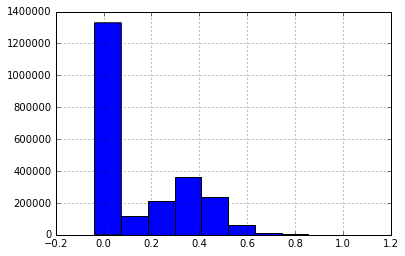

In [47]:
pd.Series(y_pred).hist()

In [54]:
sub1 = pd.DataFrame({"test_id":test_id,"is_duplicate":y_pred},columns=["test_id","is_duplicate"])

In [57]:
sub1.to_csv("../submit/sub1.csv",index=False, header=True, cols=["test_id","is_duplicate"])